# instructions:

This Jupyter Notebook can be used to search the Scielo network for desired keywords or phrases pertaining to research topics. For example, you can search for 'niobium', 'aerospace', or 'soybean biodiesel'. 

Note that if you search for a phrase with multiple words only clusters which contain all of that phrase's constituent words will show up in the results. Please do not include any punctuation in the search term. 

You can change the following parameters:
- the search term by setting the variable 'query'
- the threshold for the minimum number of times a keyword must appear in a cluster to include it in search results, 'mycount'
- the ID of the specific cluster you'd like to read through for detailed bibliographic information. Look at this after running previous cells.

Don't change any of the other code or it won't work!

After you have adjusted the parameters you want, go to the "Cell" menu at the top left and click "Run All" to see results, or run cells one at a time by clicking the "Run" button (in between the down arrow and the stop buttons). 

In [82]:
#don't change anything here
import copy
from collections import Counter
import pandas as pd
import numpy as np
import networkx as nx
import nltk
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from adjustText import adjust_text

nltk.download('punkt')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

ps = PorterStemmer()
G1 = nx.read_gpickle('network_part1.pkl')
G2 = nx.read_gpickle('network_part2.pkl')
G3 = nx.read_gpickle('network_part3.pkl')
G4 = nx.read_gpickle('network_part4.pkl')
G = nx.compose(G1, G2)
G = nx.compose(G, G3)
G = nx.compose(G, G4)

groups = {}
grouplist = []
IDlist = []
x = []
y = []

for node in G.nodes():
    if type(node) == int:
        groups.setdefault(G.node[node]['group'],[]).extend(list(set(G.node[node]['TA_words'])))
        grouplist.append(G.node[node]['group'])
        IDlist.append(G.node[node]['index'])
        x.append(G.node[node]['viz']['position']['x'])
        y.append(G.node[node]['viz']['position']['y'])
        
nodeframe = pd.DataFrame({'ID': IDlist, 'Group': grouplist, 'x': x, 'y': y})
nodeframe.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eprot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Group,ID,x,y
0,1,23549,-1724.9526,-3686.4402
1,1,22162,-1685.4515,-3683.2970
2,1,7646,-1643.9688,-3679.7146
3,1,19787,-1720.4603,-3644.8289
4,1,14260,-1613.8620,-3717.5273


### replace the text inside the quotes in the next cell to set the keyword you want to search for

In [66]:
query = nltk.word_tokenize('biodiesel')

### this is the threshold for the minimum number of papers in a cluster that should contain each keyword. Set to 1 for the broadest possible search and increase if you want more specific resuls. 

In [67]:
mycount = 2

In [68]:
#don't change anything here
for i in query:
    i = i.lower()
    i = ps.stem(i)

cluster_dict = {}
cluster_list = []
count_list = []
for i in groups:
    allthere = 1
    count = 9999
    for j in query:
        temp = groups[i].count(j)
        allthere = allthere * temp
        if temp < count:
            count = copy.deepcopy(temp)
    
    if count >= mycount and allthere > 0:
        cluster_dict[i] = {}
        cluster_dict[i]['nodes'] = []
        cluster_dict[i]['count'] = count
        count_list.append(cluster_dict[i]['count'])
        cluster_list.append(i)
        
for node in G.nodes():
    if G.node[node]['group'] in cluster_list:
        temp = copy.deepcopy(G.node[node])
        temp.pop('TA', None)
        temp.pop('TA_words', None)
        temp.pop('viz', None)
        cluster_dict[G.node[node]['group']]['nodes'].append(temp)

### the next cell shows search results for specific clusters, in a graph and a table

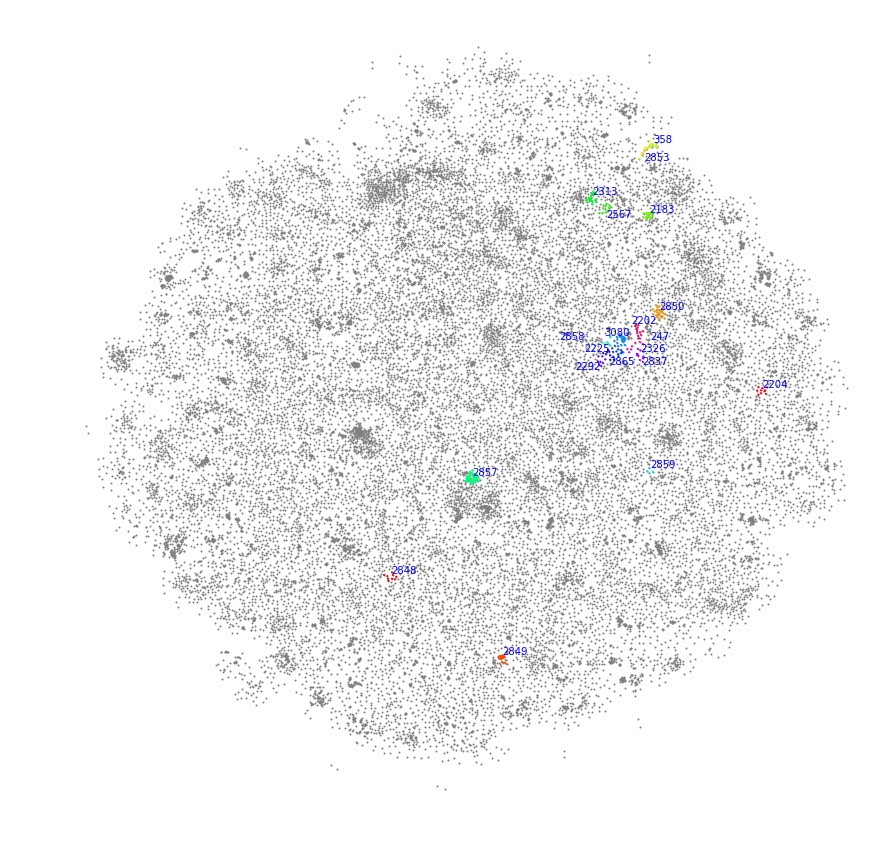

,hits,# papers,keywords
ID,,,
247,2,9,weight harvest vibrat extract remov fourier infrar solut capac prepar
358,2,30,clay materi properti ray diffract surfac natur bentonit prepar thermal
2183,2,30,oil acid fatti extract fruit composit free oxid avocado lipid
2202,2,12,glycerin crude diet inclus matter complet replic digest corn rumin
2204,5,19,glycerin diet inclus weight crude feed fed contain replic anim
2225,3,29,meal diet soybean fed anim weight feed matter decreas cake
2292,2,12,matter protein silag energi complet cow holstein corn cell could
2313,2,23,matter protein neutral deterg fiber degrad crude digest rumin diet
2326,2,55,seed physiolog germin storag store harvest month vigor seedl emerg


In [88]:
cluster_results = pd.DataFrame({'ID': cluster_list, 'hits': count_list})
cluster_results = cluster_results.set_index('ID')
cluster_results['# papers'] = 0
cluster_results['keywords'] = ''

for i in range(1,max(groups)+1):
    if i in cluster_results.index.values:
        cluster_results.loc[i, '# papers'] = len(cluster_dict[i]['nodes'])
        cluster_results.loc[i, 'keywords'] = ' '.join(t[0] for t in Counter(groups[i]).most_common(10))

nodehits = copy.deepcopy(nodeframe)
nodehits['bool'] = nodehits['Group'].isin(list(cluster_results.index))
nodehits = nodehits[nodehits['bool'] == True]
nodehits['group_color'] = pd.factorize(nodehits['Group'])[0]
cluster_results['x'] = nodehits.groupby('Group')['x'].mean()
cluster_results['y'] = nodehits.groupby('Group')['y'].mean()

fig, ax = plt.subplots(figsize=(15,15))
ax.axis("off")
ax.scatter(np.array(nodeframe[['x' ,'y']])[:,0], np.array(nodeframe[['x' ,'y']])[:,1], c="gray", s=1)
ax.scatter(np.array(nodehits[['x', 'y']])[:,0], np.array(nodehits[['x', 'y']])[:,1], c=list(nodehits['group_color']), cmap = plt.get_cmap("hsv"), s=1)
texts = [plt.text(list(cluster_results['x'])[i], list(cluster_results['y'])[i], list(set(list(nodehits['Group'])))[i], color='blue') for i in range(len(list(cluster_results['x'])))]
adjust_text(texts)
    
cluster_results = cluster_results.drop(['x', 'y'], axis=1)
plt.show()  
cluster_results

In [12]:
#don't change anything here
authors = []
institutions = []

for i_id, i_item in cluster_dict.items():
    for j in i_item['nodes']:
        authors.extend(j['authors'])
        institutions.extend(j['affiliations'])

### this lists the most common authors from the search
syntax is ('Author Name', # hits)

In [13]:
#don't change anything here
Counter(authors).most_common(20)

[('Joao Almir Oliveira', 6),
 ('Osvaldo Resende', 4),
 ('Roberio Rodrigues Silva', 3),
 ('Fabiano Ferreira da Silva', 3),
 ('Jose Neuman Miranda Neiva', 3),
 ('Telma Teresinha Berchielli', 3),
 ('Marco Antonio Previdelli Orrico Junior', 3),
 ('Alice Watte Schwingel', 3),
 ('Ana Carolina Amorim Orrico', 3),
 ('J.M.B. Ezequiel', 3),
 ('A.C. Homem Junior', 3),
 ('Heloisa Oliveira dos Santos', 3),
 ('Stefania Vilas Boas Coelho', 3),
 ('Eduardo Euclydes de Lima e Borges', 3),
 ('Everson Reis Carvalho', 3),
 ('Juliana de F. Sales', 3),
 ('Renato Mendes Guimaraes', 3),
 ('Franciele Caixeta', 3),
 ('Renato Cataluna', 2),
 ('Fabricia Rocha Chaves Miotto', 2)]

### this lists the most common institutions
syntax is ('Institution', # hits)

In [14]:
#don't change anything here
Counter(institutions).most_common(10)

[('Departamento de Agricultura, UFLA, Caixa Postal 3037, 37200-000 - Lavras, MG, Brasil.',
  5),
 ('Departamento de Engenharia Florestal, Universidade Federal dos Vales do Jequitinhonha e Mucuri - UFVJM, Diamantina/MG, Brazil',
  2),
 ('Universidade Federal do Tocantins, Escola de Medicina Veterinaria e Zootecnia, Araguaina, TO, Brasil.',
  2),
 ('Programa de Pos-graduacao em Zootecnia, Universidade Federal de Campina Grande, Patos, Paraiba, Brazil.',
  2),
 ('Universidade Federal de Mato Grosso do Sul, Faculdade de Medicina Veterinaria e Zootecnia, Campo Grande, MS, Brazil.',
  2),
 ('Universidade Federal de Minas Gerais, Escola de Veterinaria, Departamento de Zootecnia, Belo Horizonte, MG, Brazil.',
  2),
 ('Universidade Federal da Bahia - UFBA - Salvador, BA', 2),
 ('Universidade Federal Rural de Pernambuco - UFRPE - Recife, PE', 2),
 ('PDIZ/CCA/UFPB - Pesquisador do CNPq.', 2),
 ('Universidade Federal da Grande Dourados, Faculdade de Ciencias Agrarias, Caixa Postal 533, 79804-970 -

### change the number in the square brackets to the cluster ID you want to examine

In [11]:
cluster_dict[2183]['nodes']

[{'abstract': 'Vegetable oils are suitable for human consumption as part of a healthy diet and native fruits of the cerrado, such as almond baru, which are natural sources of these oils. This study informed about the quality of baru oil having as a basis for comparison, soybean oil and olive oil, usually consumed in human diet. Analyzes of acid value, peroxide and iodine for the three oils and fatty acid composition for the baru oil were performed according to official standard methodology. Baru oil has the potential to be part of the human consumption, in healthy diets similarly to soybean oil and olive oil.',
  'affiliations': ['Departamento de Tecnologia de Alimentos, Instituto Federal Goiano, Campus Morrinhos, 75650-000, Morrinhos, GO, Brasil.',
   'Programa de Pos-graduacao em Agroquimica, Instituto Federal Goiano, Rio Verde, GO, Brasil.',
   'Departamento de Agronomia, Instituto Federal Goiano, Urutai, GO, Brasil.'],
  'authors': ['Ana Paula Silva Siqueira',
   'Carlos Frederico 